data-making 
generating transit curves dataset using batman and python
the original simulated data has 10,000 data points and the new test data has 1000 data points

In [ ]:
import batman  
import numpy as np 
import csv
import random  
import matplotlib.pyplot as plt
import os

In [ ]:
#object to store transit parameters
params = batman.TransitParams()

In [ ]:
#defining column names for storing the data in csv file
column_names = [' time_inf_cong ', ' orbital period ', ' planet radius ', ' semi-major axis ', ' orbital inclination ',' eccentricity ',' logitude ',' limb darkening model ','label']

In [ ]:
#directory that stores the transit images of the first simulated dataset which is used to train the SVM model
if not os.path.exists('transit_images'):
    os.makedirs('transit_images')

#directory that stores the transit images of the second simulated dataset
"""
if not os.path.exists('transit_images_new_test_data'):
    os.makedirs('transit_images_new_test_data')
"""

In [ ]:
with open('original_simulated_data.csv', 'w', newline='') as file:
  """
#with open('new_test_data.csv', 'w', newline='') as file:
"""  
  # Create a CSV writer object
  writer = csv.writer(file)
    
  # Write the column names to the CSV file
  writer.writerow(column_names)
  for i in range(10000):
    params.t0 = 0.                                                      # time of inferior conjunction (days)  
    params.per = np.random.uniform(0.01, 1)                             # orbital period (days)
    params.rp = np.random.uniform(0.01, 0.03)                           # planet radius (in units of the stellar radius)
    params.a = np.random.uniform(5, 15)                                 # semi-major axis (in units of the stellar radius)
    params.inc = np.random.uniform(80, 90)                              # orbital inclination (in degrees)
    params.ecc = np.random.uniform(0, 0.05)                             # eccentricity
    params.w = np.random.uniform(30, 360)                               # longitude of periastron (in degrees)
    ld_options = ["uniform", "linear", "quadratic", "nonlinear"]        # limb darkening model
    ld_coefficients = [[], [0.3], [0.1, 0.3], [0.5, 0.1, 0.1, -0.1]]    # limb darkening coefficients
 
# Generate a batman transit model using the specified parameters
    t = np.linspace(-0.025, 0.025, 1000)                                # time array
  
  
    for j in range(4):
      params.limb_dark = ld_options[j]                                  #specifies the LD profile
      params.u = ld_coefficients[j]                                     #updates LD coefficients
      m = batman.TransitModel(params, t)                                #initializes the model
      flux = m.light_curve(params)
    dydx = np.diff(flux) / np.diff(t)


# Plot the simulated transit curve
    
    plt.plot(t, flux, label=ld_options[j])
    if np.max(np.abs(dydx)) >0.0:
      label=1
    else:
      label=0
    writer.writerow([params.t0, params.per, params.rp, params.a, params.inc, params.ecc, params.w,params.limb_dark,label])
    plt.savefig(f'transit_images/transit_curve{i}.png')
    #plt.savefig(f'transit_images_new_test_data/transit_curve__new_test_data{i}.png')
    plt.xlabel('Time (days)')
    plt.ylabel('Flux')
    plt.show()
    
  

Training support vector machine classifier on the simulated dataset

In [33]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import  confusion_matrix, classification_report,roc_auc_score
import joblib


In [34]:
data=pd.read_csv("original_simulated_data.csv")
data.head()

,time_inf_cong,orbital period,planet radius,semi-major axis,orbital inclination,eccentricity,logitude,limb darkening model,label
0,0,0.569675,0.023705,9.924401,85.676463,0.043150,258.316219,nonlinear,1
1,0,0.773985,0.023658,7.162162,87.971533,0.027861,116.344127,nonlinear,1
2,0,0.076325,0.022901,5.060673,81.105097,0.020766,86.949186,nonlinear,1
3,0,0.600224,0.029756,12.440732,88.323040,0.048275,289.930890,nonlinear,1
4,0,0.832571,0.010328,8.314811,88.993988,0.029511,239.905530,nonlinear,1


In [35]:
data.shape

(10000, 9)

In [36]:
x=data.iloc[:,1:-2]
y = data['label']

In [37]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0    orbital period        10000 non-null  float64
 1    planet radius         10000 non-null  float64
 2    semi-major axis       10000 non-null  float64
 3    orbital inclination   10000 non-null  float64
 4    eccentricity          10000 non-null  float64
 5    logitude              10000 non-null  float64
dtypes: float64(6)
memory usage: 468.9 KB


<Axes: >

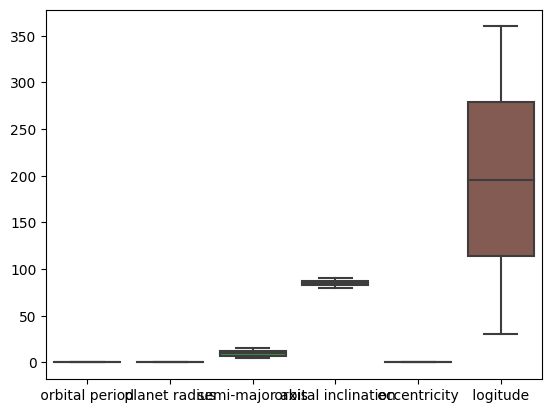

In [38]:
sns.boxplot(data=x)

In [39]:
#checking for duplicate values
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

0


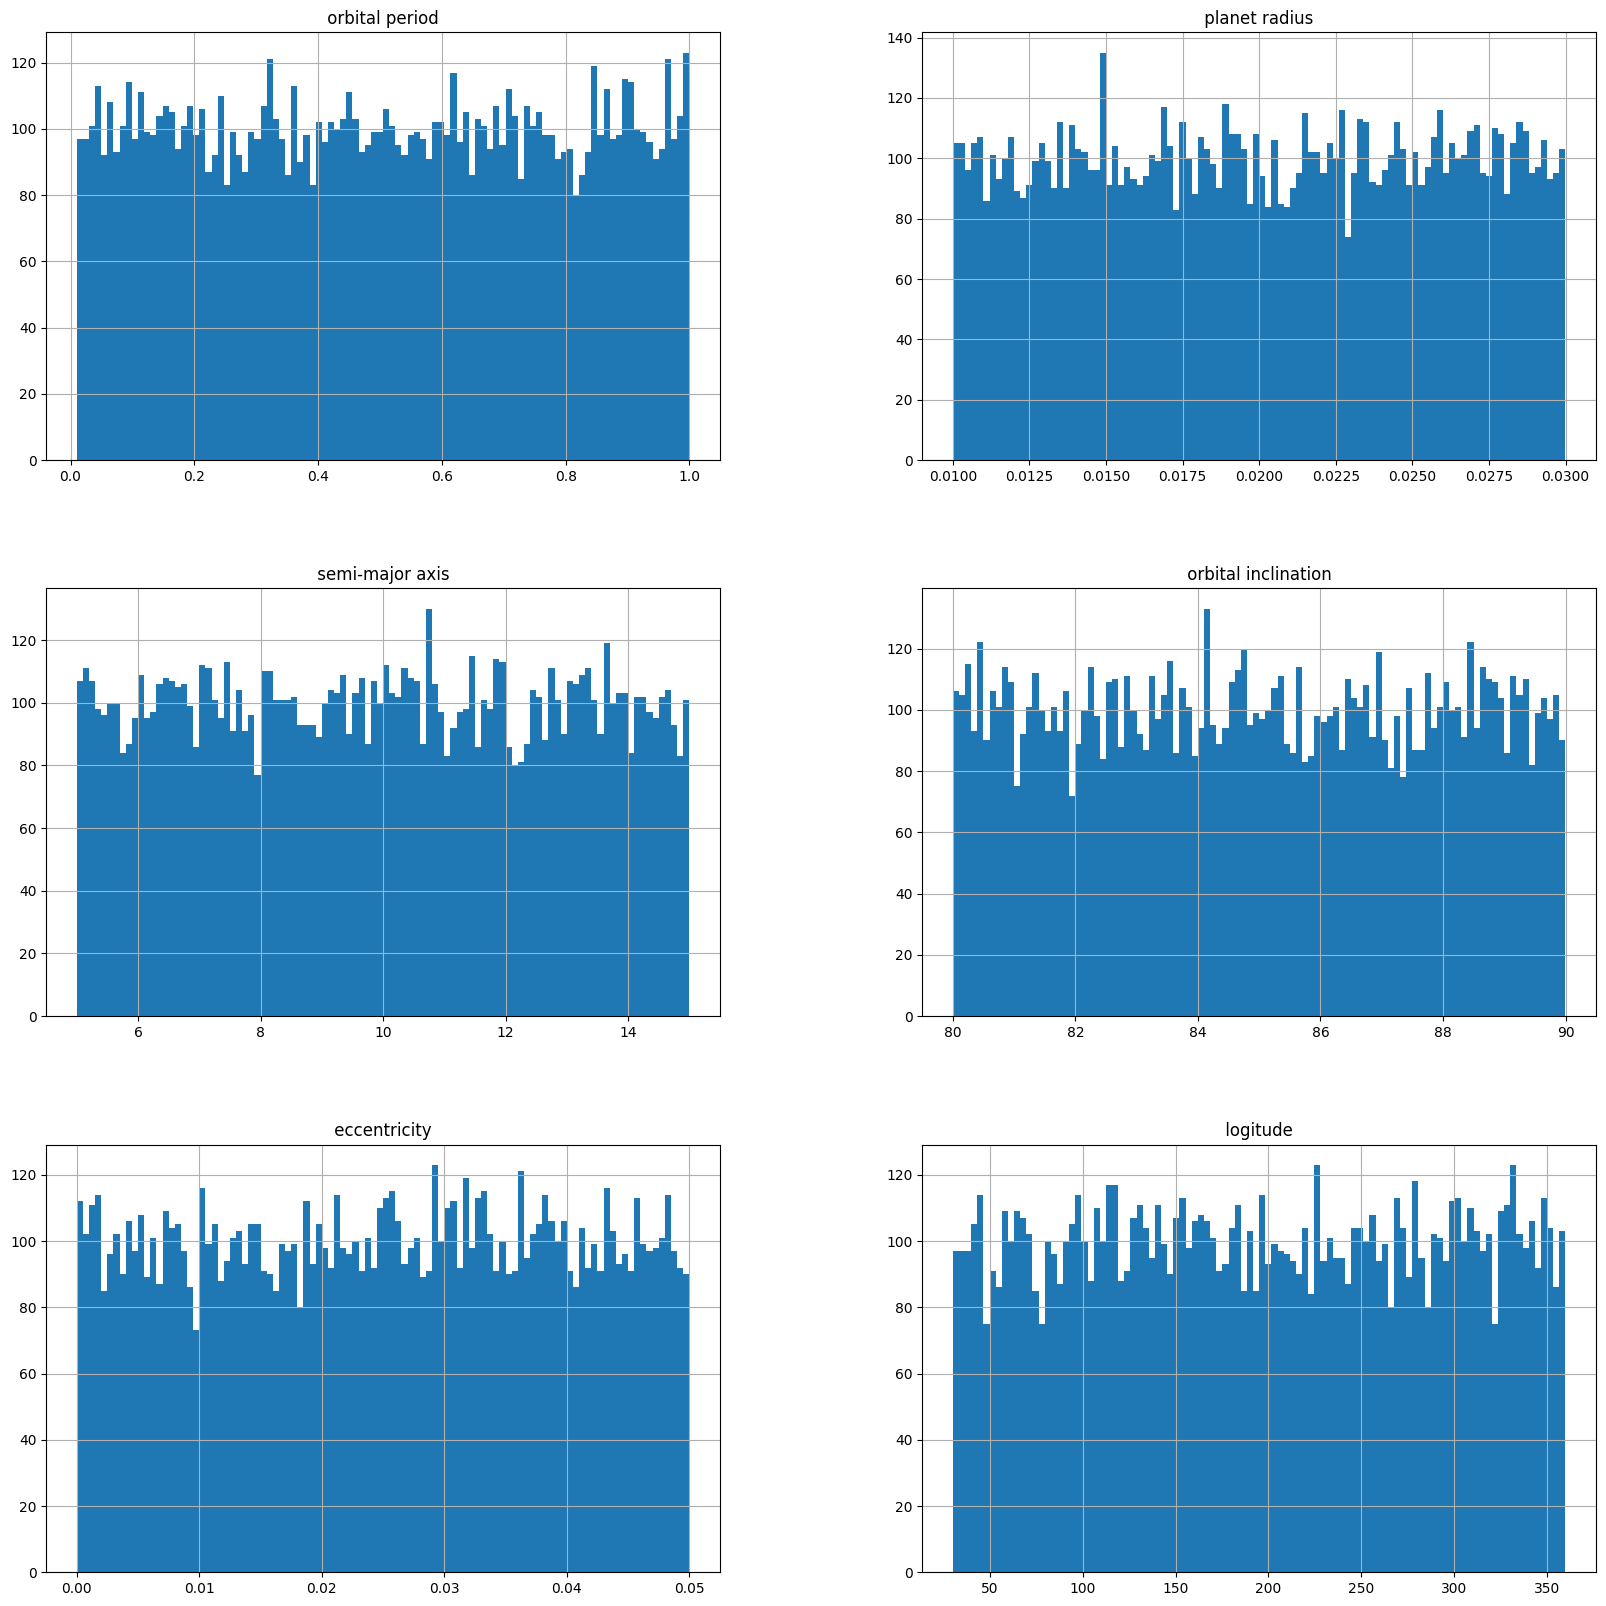

In [40]:
x.hist(bins = 100,figsize = (20,20))
plt.show()

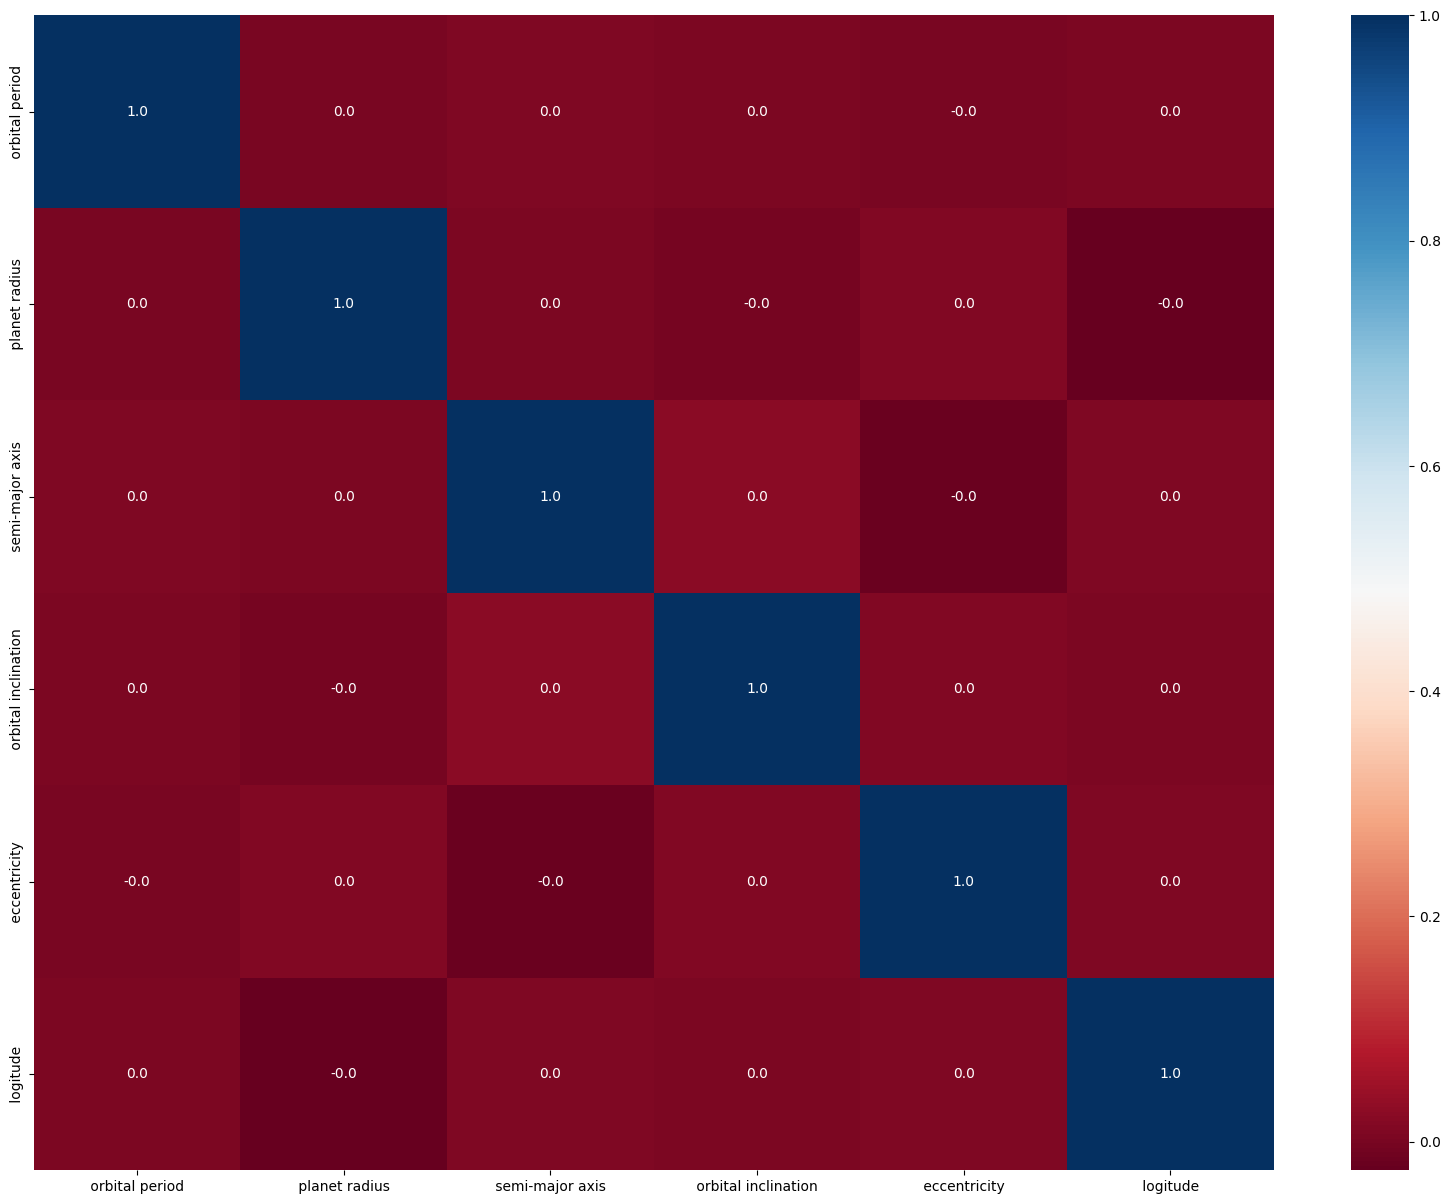

In [41]:
#heat map, to see the correlation between features
plt.figure(figsize=(20,15))
sns.heatmap(x.corr(),cmap="RdBu",annot=True, fmt=".1f")
plt.show()


In [42]:
x.describe()

,orbital period,planet radius,semi-major axis,orbital inclination,eccentricity,logitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.505845,0.020036,9.984455,84.991521,0.025068,195.764135
std,0.287670,0.005783,2.882545,2.898469,0.014407,95.240693
min,0.010017,0.010001,5.000404,80.000099,0.000002,30.015376
25%,0.255317,0.014988,7.462898,82.509884,0.012640,113.917702
50%,0.505810,0.019996,10.000193,84.958015,0.025343,195.274614
75%,0.753870,0.025076,12.500065,87.520299,0.037456,278.827983
max,0.999823,0.029995,14.998215,89.999151,0.049996,359.968996


model training(i have choosen a pre-trained model,support vector machine)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)


In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
joblib.dump(svm, 'svm_model.pkl')

['svm_model.pkl']

In [46]:
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test, y_pred))


[[1365   29]
 [  16 2590]]


In [47]:
print(roc_auc_score(y_test, y_pred))

0.9865284395022634


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1394
           1       0.99      0.99      0.99      2606

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



testing the above trained SVM model on the new test data

In [49]:
import joblib

In [50]:
load_model = joblib.load('svm_model.pkl')


In [51]:
new_data = pd.read_csv('new_test_data.csv')
new_data.head()

,time_inf_cong,orbital period,planet radius,semi-major axis,orbital inclination,eccentricity,logitude,limb darkening model,label
0,0.0,0.870281,0.010179,11.962290,85.858435,0.022067,178.752243,nonlinear,1
1,0.0,0.083084,0.017664,13.398730,85.350405,0.026334,319.917020,nonlinear,0
2,0.0,0.591845,0.025220,6.278751,81.670886,0.035437,101.569167,nonlinear,1
3,0.0,0.741812,0.020910,13.092536,85.995801,0.045646,148.874166,nonlinear,1
4,0.0,0.134501,0.016463,7.311239,88.764576,0.037108,277.039005,nonlinear,1


In [52]:
new_data.shape

(1000, 9)

In [53]:
x_new=new_data.iloc[:,1:-2]
y_new=new_data["label"]

In [54]:
x_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0    orbital period        1000 non-null   float64
 1    planet radius         1000 non-null   float64
 2    semi-major axis       1000 non-null   float64
 3    orbital inclination   1000 non-null   float64
 4    eccentricity          1000 non-null   float64
 5    logitude              1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


In [55]:
print(x_new.duplicated().sum())
new_data.drop_duplicates(inplace=True)

0


In [56]:
scaler = StandardScaler()
X_test = scaler.fit_transform(x_new)

In [57]:
predictions = load_model.predict(X_test)

In [58]:
print(confusion_matrix(y_new, predictions))


[[357   9]
 [  1 633]]


In [59]:
print(roc_auc_score(y_new, predictions))

0.9869162744996638


In [60]:
print(classification_report(y_new, predictions))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       366
           1       0.99      1.00      0.99       634

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

